# STARMap cell type clustering analysis

10-15-2020

## 1. Background

STARMap (Spatially Resolved Transcript Amplicon Readout Mapping) is a new in-situ RNA sequencing method, which is based on integration of hydrogel-tissue chemistry and targeted signal amplification. It enables simultaneous analysis of multiple RNAs in intact, bulky samples. This example will try to regenerate some parts of result from the STAPmap analysis pipeline, especially focus on the single-cell top-level clustering and sub-level clustering. After normalization and scaling of the expression profile for each cell in each sample, PCA and UMAP are used for dimentionality reduction. Then louvain clustering is applied to identify different cell type clusters based on basic neuronal cell type markers. The inhibitory, excitatory, and non-neuronal clusters were then subclustered using the same approach as applied to the major clusters. 

![pipeline](https://jiahaoh.com/project/pipeline_example.png)

*Fig.S4 Wang(2018)*

In [254]:
# Loading the Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from anndata import AnnData, concat
from matplotlib.colors import ListedColormap
from starmap.obj import STARMapDataset, load_data

import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su
import matplotlib.pyplot as plt

# test
# from starmap.utilities import *
# test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Input

In [224]:
# Load the data

base_path = "/Users/jiahao/Project/starmap_example/mpfc_160/"
data_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

objs = []
batches = []
for i, folder in enumerate(data_folders):
    exp_path = os.path.join(base_path, folder, 'output/b001')
    exp_files = [f for f in os.listdir(exp_path)]
    
    # add expression data to the object 
    print(f"Loading data: {folder}")
    curr_adata = sc.read_csv(os.path.join(exp_path, exp_files[1]))
    objs.append(curr_adata)
    batches.append(folder)

adata = concat(objs, label="batch", keys=batches)
var = pd.read_csv(os.path.join(exp_path, exp_files[2]), names=['1', '2', 'Gene'])
marker_type = pd.read_csv(os.path.join(base_path, '166genes.csv'), names=['Gene', 'Marker_type'])
var = pd.merge(var, marker_type, on='Gene')
var = pd.DataFrame({'Marker_type': var['Marker_type'].values}, index=var['Gene'])
adata.var = var
adata.obs['orig_index'] = adata.obs.index.values
adata.obs.reset_index(inplace=True, drop=True)

Loading data: BZ5_control
Loading data: BZ9_control
Loading data: BZ14_control
Loading data: BZ19_cocaine


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [225]:
# Load gene information 

type_markers = adata.var[(adata.var['Marker_type'] == "Type") | (adata.var['Marker_type'] == "Both")].index.to_list()
activity_markers = adata.var[adata.var['Marker_type'] == "Activity"].index.to_list()

print(f"""
Number of cell typing markers: {len(type_markers)}
Number of activity markers: {len(activity_markers)}
""")


Number of cell typing markers: 118
Number of activity markers: 48



## 3. Preprocessing

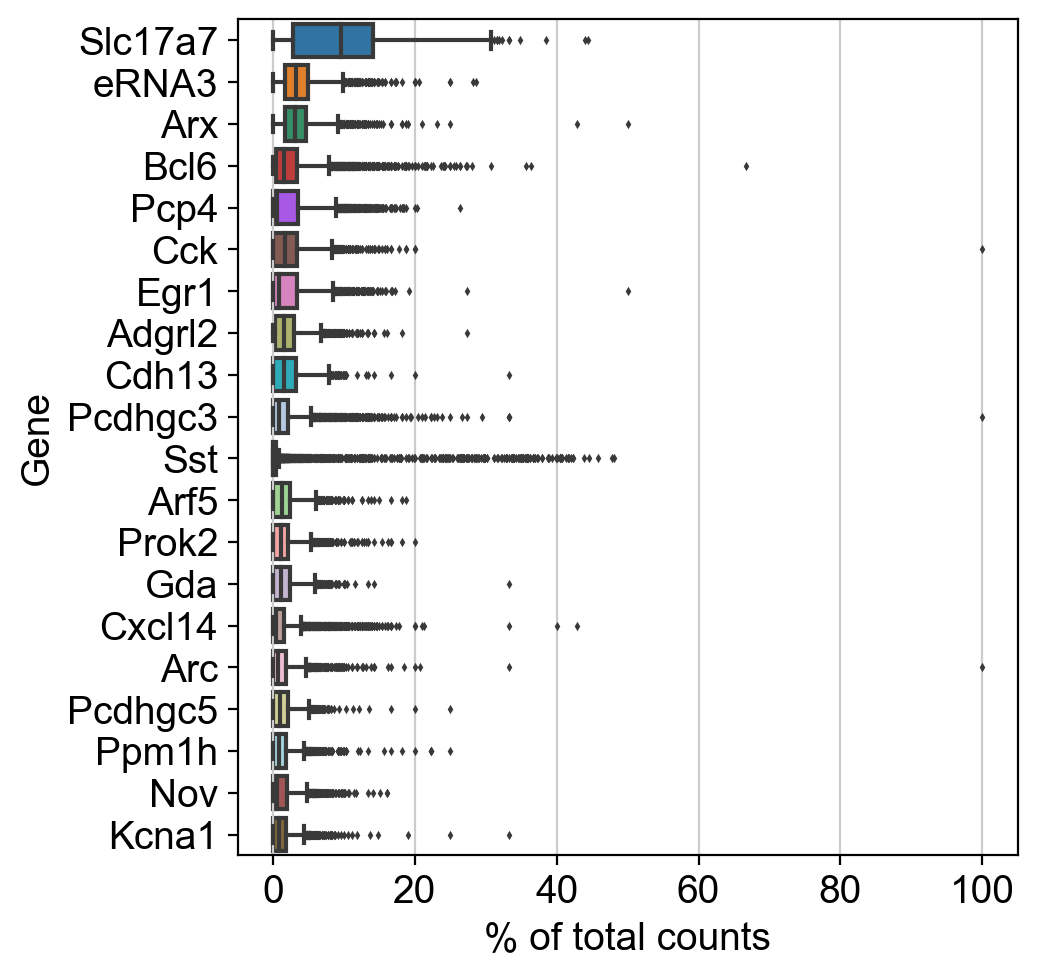

In [226]:
# Show top-20 highly expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

... storing 'orig_index' as categorical
... storing 'Marker_type' as categorical


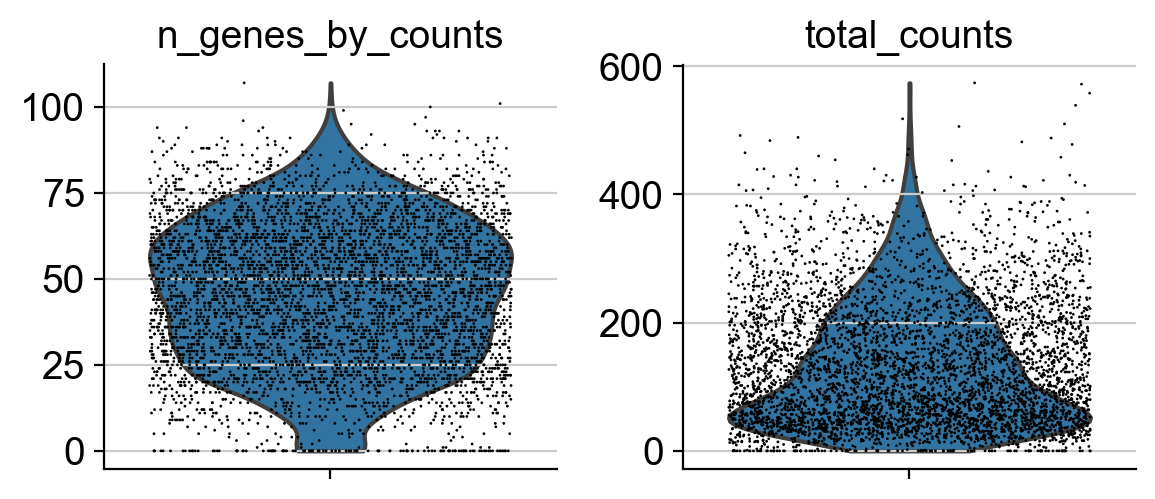

In [227]:
# Calculate QC & Per-cell Stats Plot

sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, log1p=False)

sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

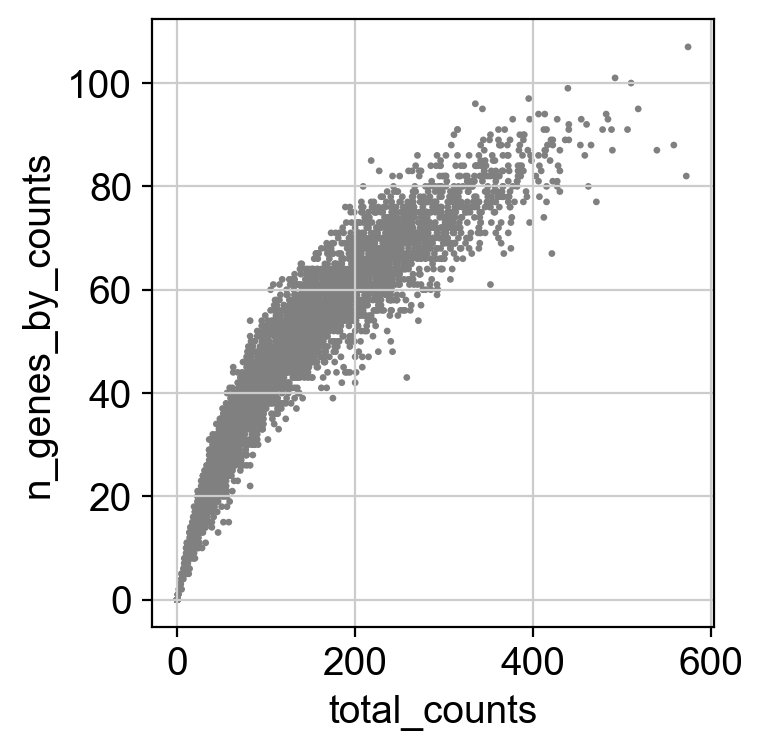

In [228]:
# Plot gene & counts relationship 

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [229]:
# Show stat info

su.show_stat(adata)
su.show_reads_quantile(adata)

Number of cells: 5045
Cells without gene: 0
Cells without reads: 108
Number of genes: 166
Number of batches: 4
Cells in each experiment: {'BZ5_control': 1127, 'BZ9_control': 1380, 'BZ14_control': 1216, 'BZ19_cocaine': 1322}

Reads per cell quantile:
0.10     29.0
0.25     55.0
0.50    113.0
0.75    198.0
0.90    271.6
Name: total_counts, dtype: float64


In [230]:
# Basic filtration 

sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_counts=29)

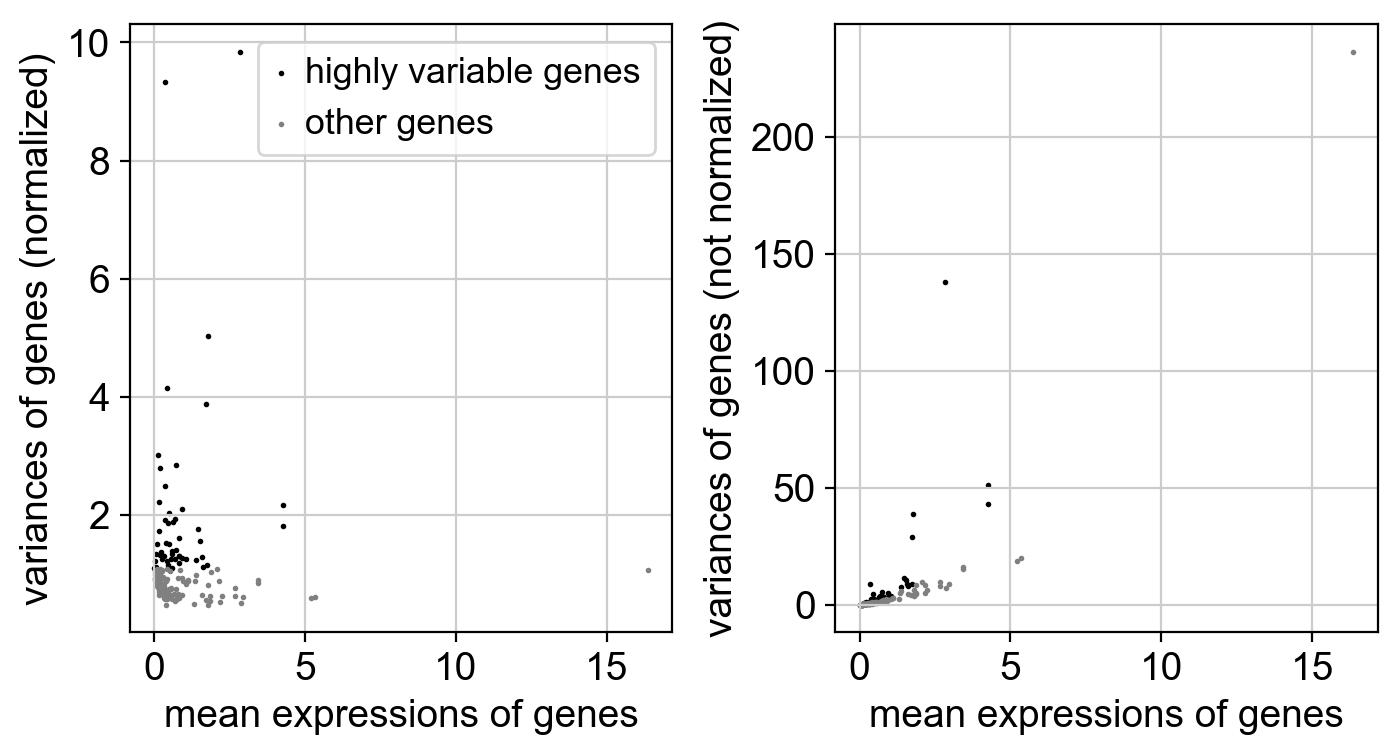

In [231]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=50)
sc.pl.highly_variable_genes(adata)

In [232]:
# Normalization
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [233]:
# Store the raw
adata.raw = adata

In [234]:
# Scaling 
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata)
# sc.pp.combat(adata)

## 4. Top-level single-cell clustering

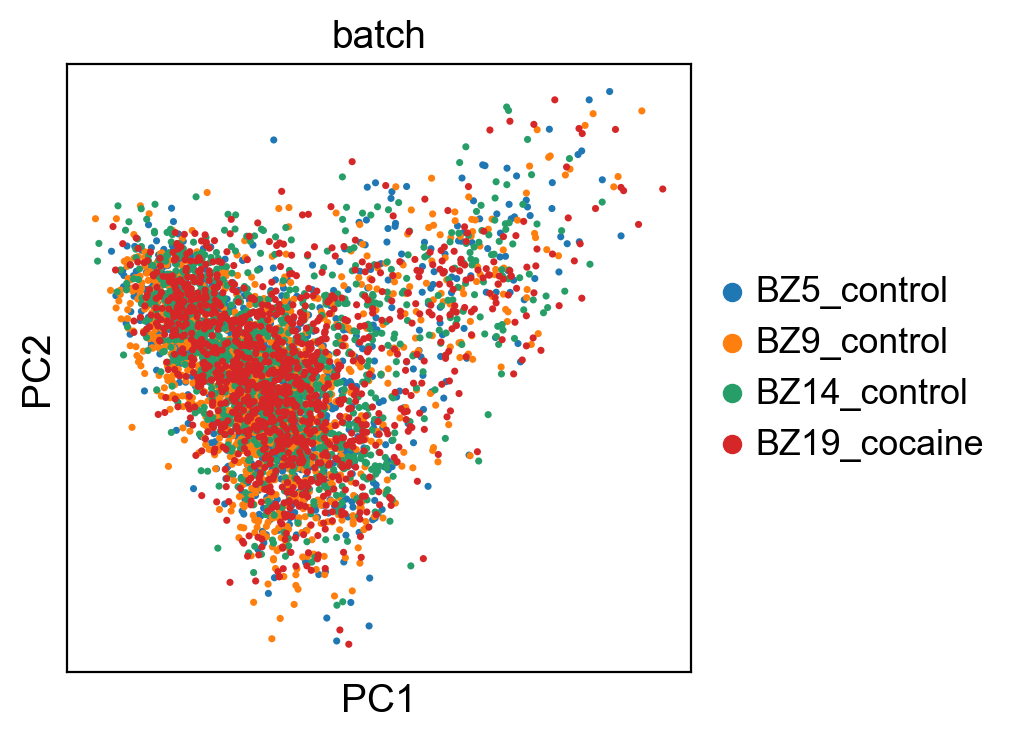

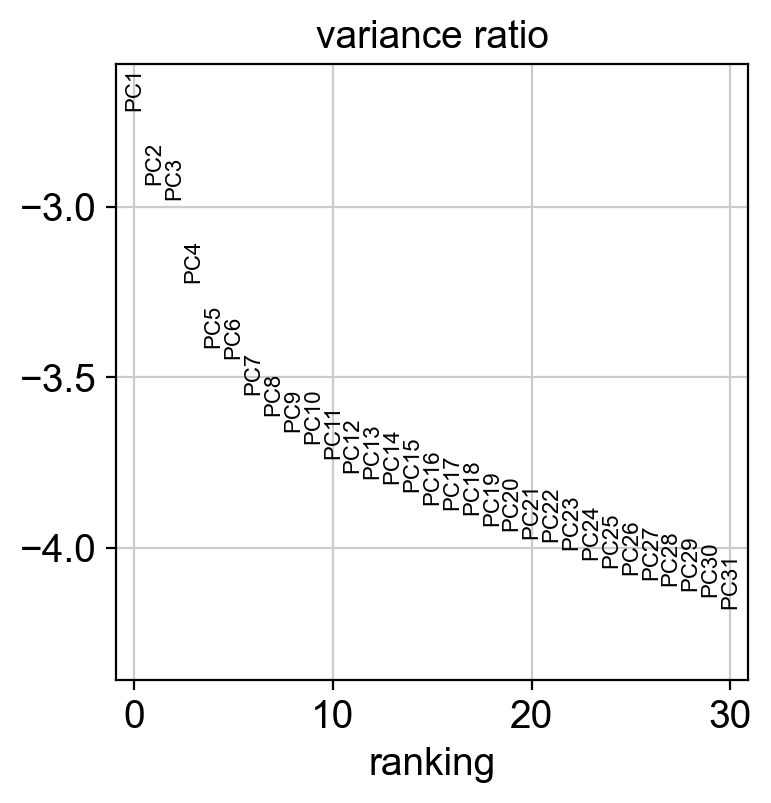

In [235]:
# PCA
sc.tl.pca(adata)


sc.pl.pca(adata, color='batch')
sc.pl.pca_variance_ratio(adata, log=True)

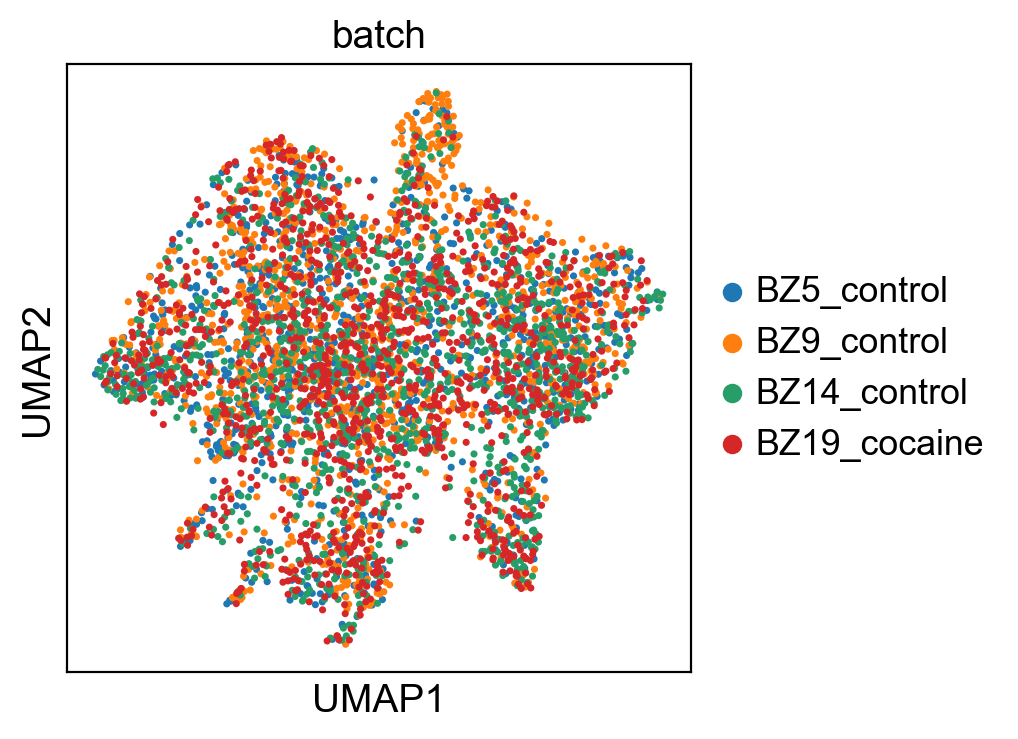

In [236]:
# UMAP

sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')

In [237]:
# Clustering

sc.tl.louvain(adata, resolution=.3)

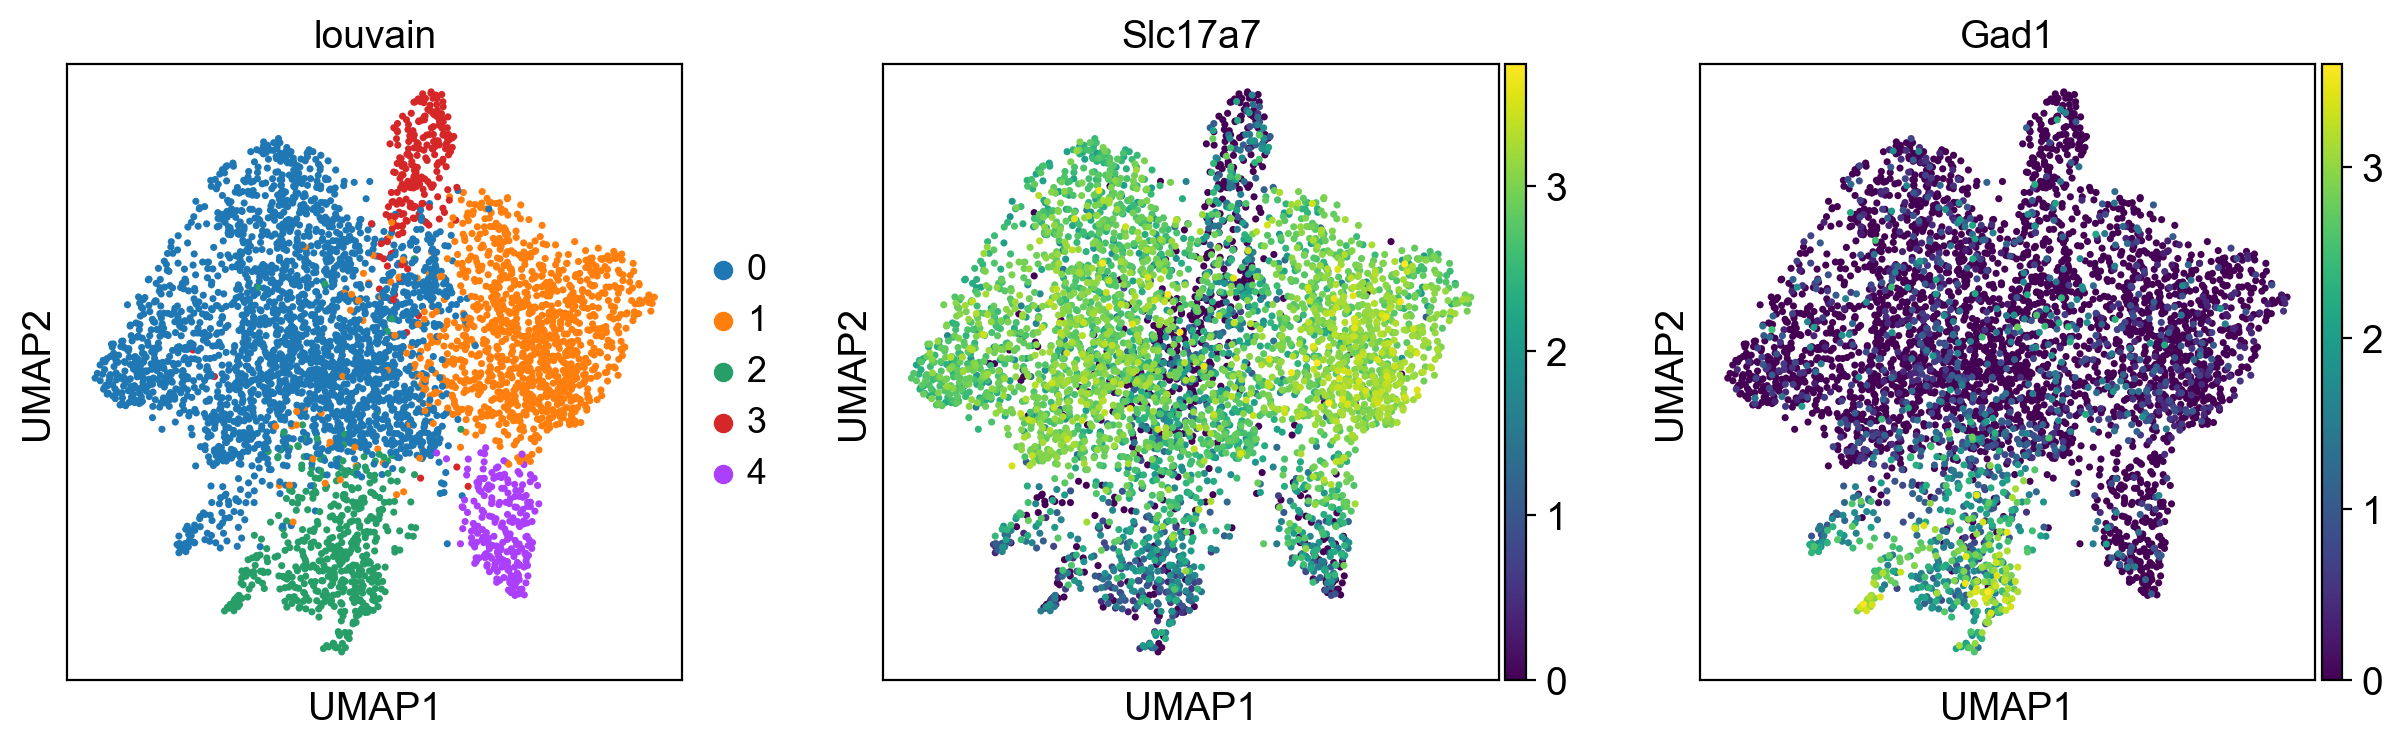

In [238]:
# UMAP with cluster and genes

sc.pl.umap(adata, color=['louvain', 'Slc17a7', 'Gad1'])

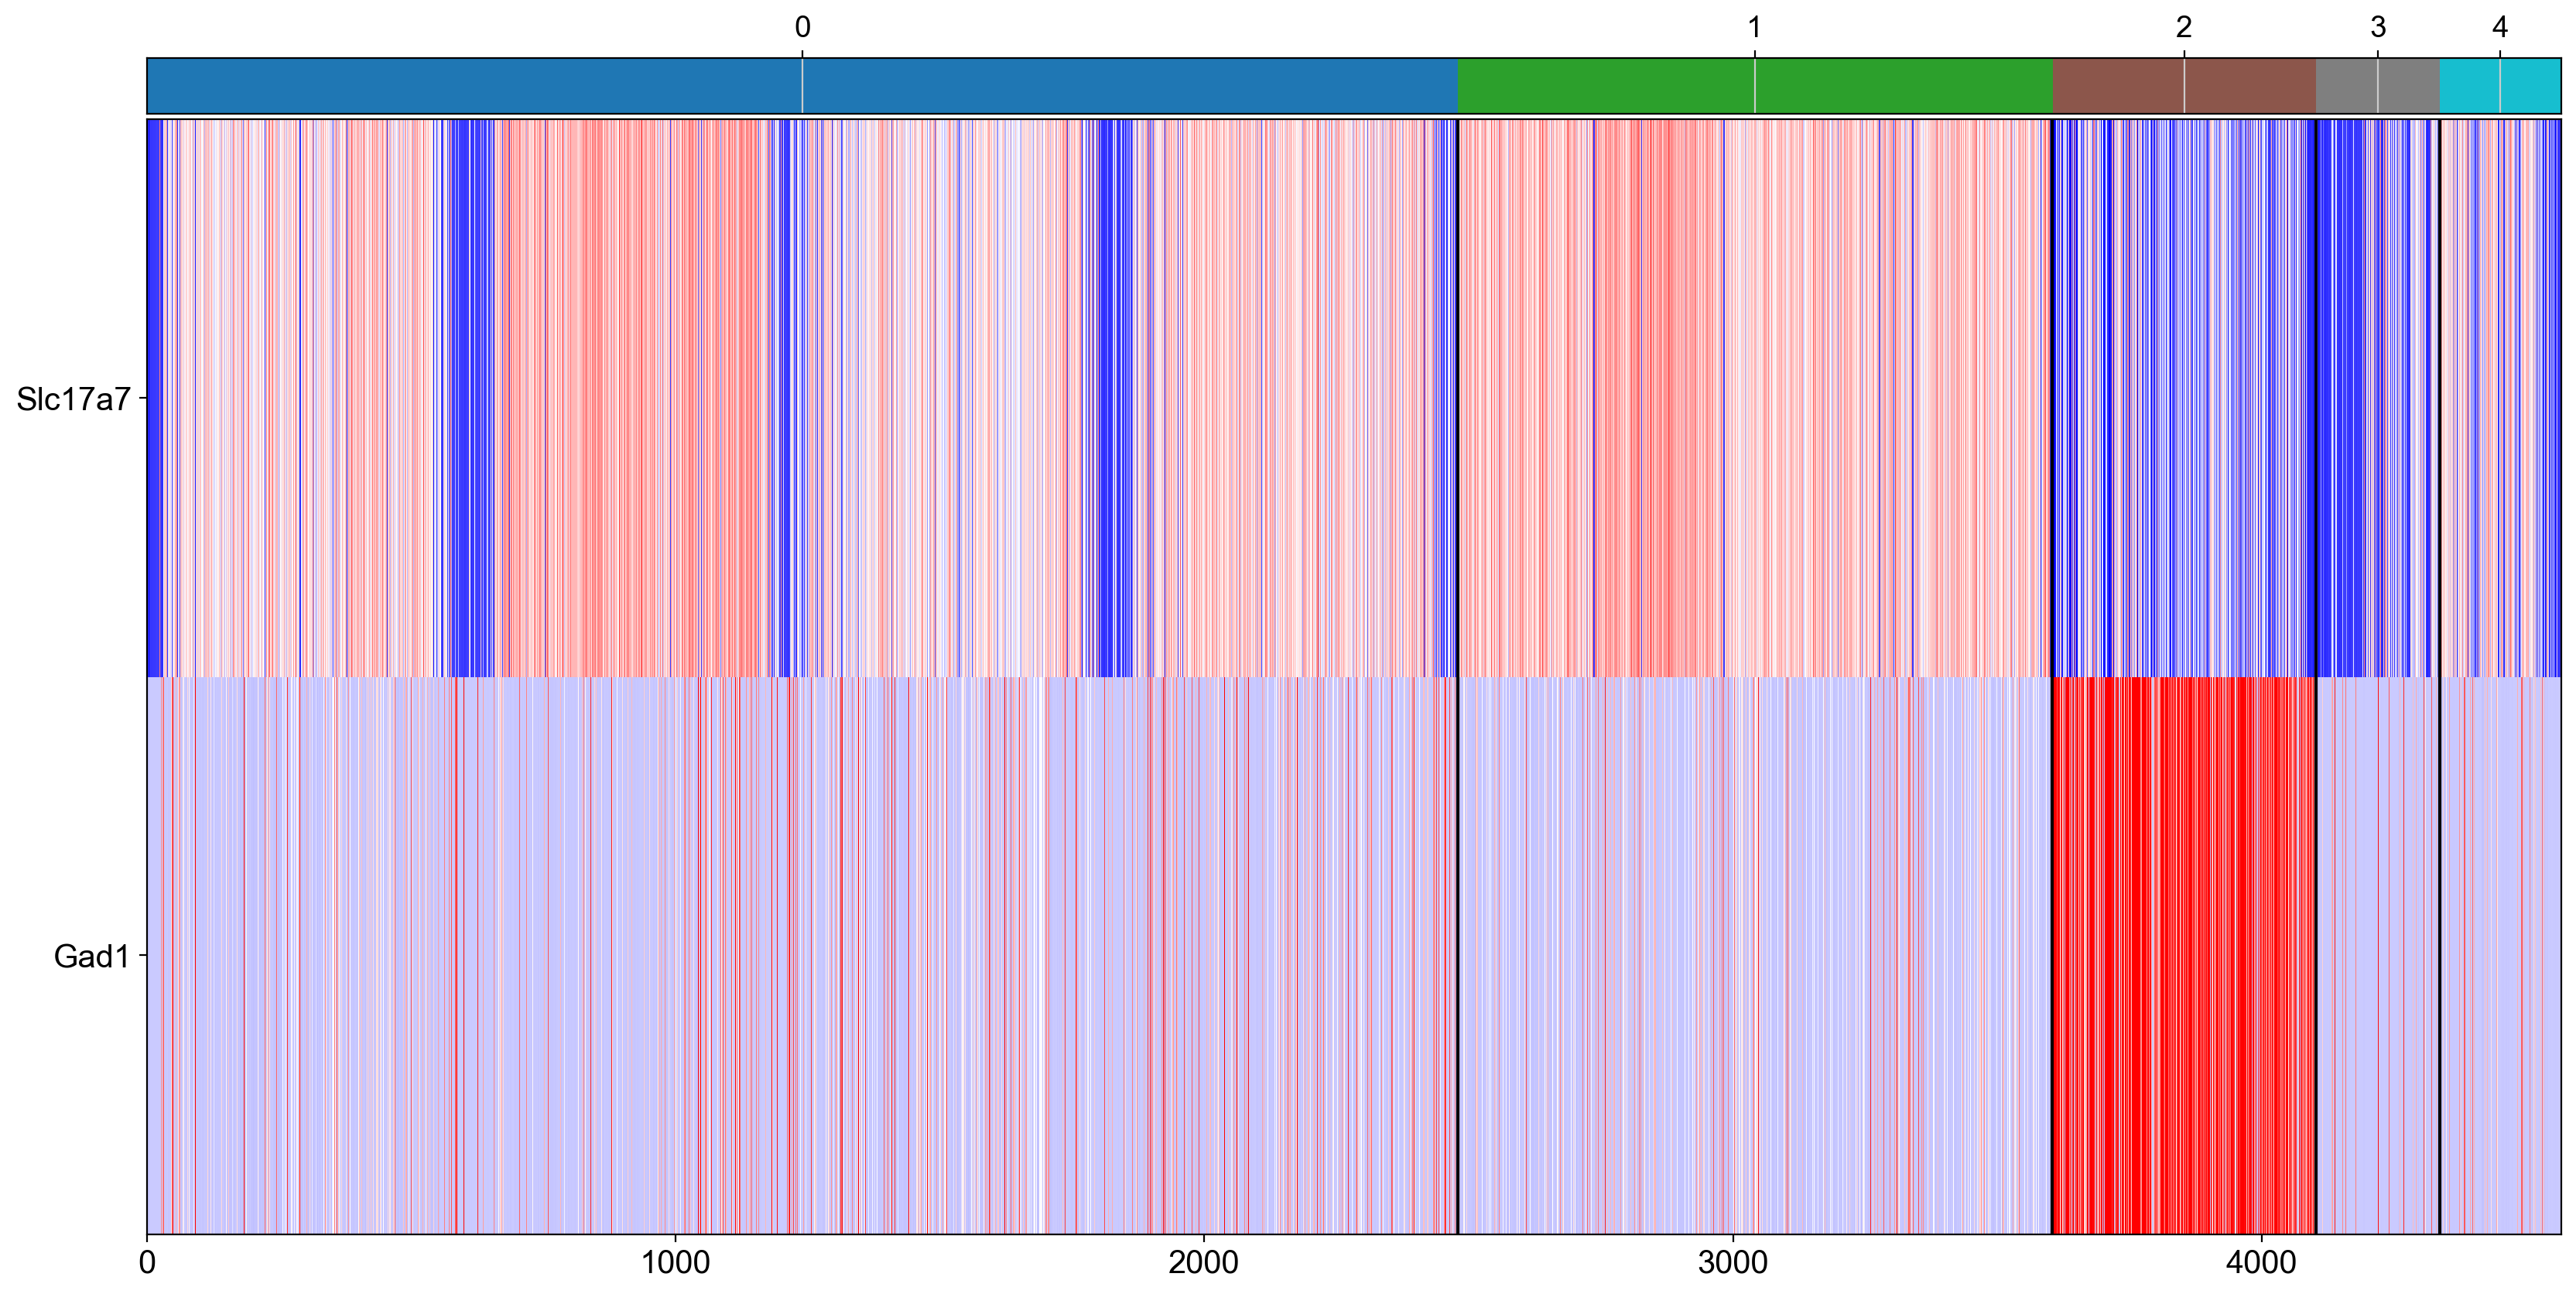

In [258]:
# Check expression profiles of selected gene markers
top_markers = ["Slc17a7", "Gad1"]

plt.figure(figsize=(20,10))
su.plot_heatmap_with_labels(adata, top_markers, 'louvain', show_axis=True, font_size=15)

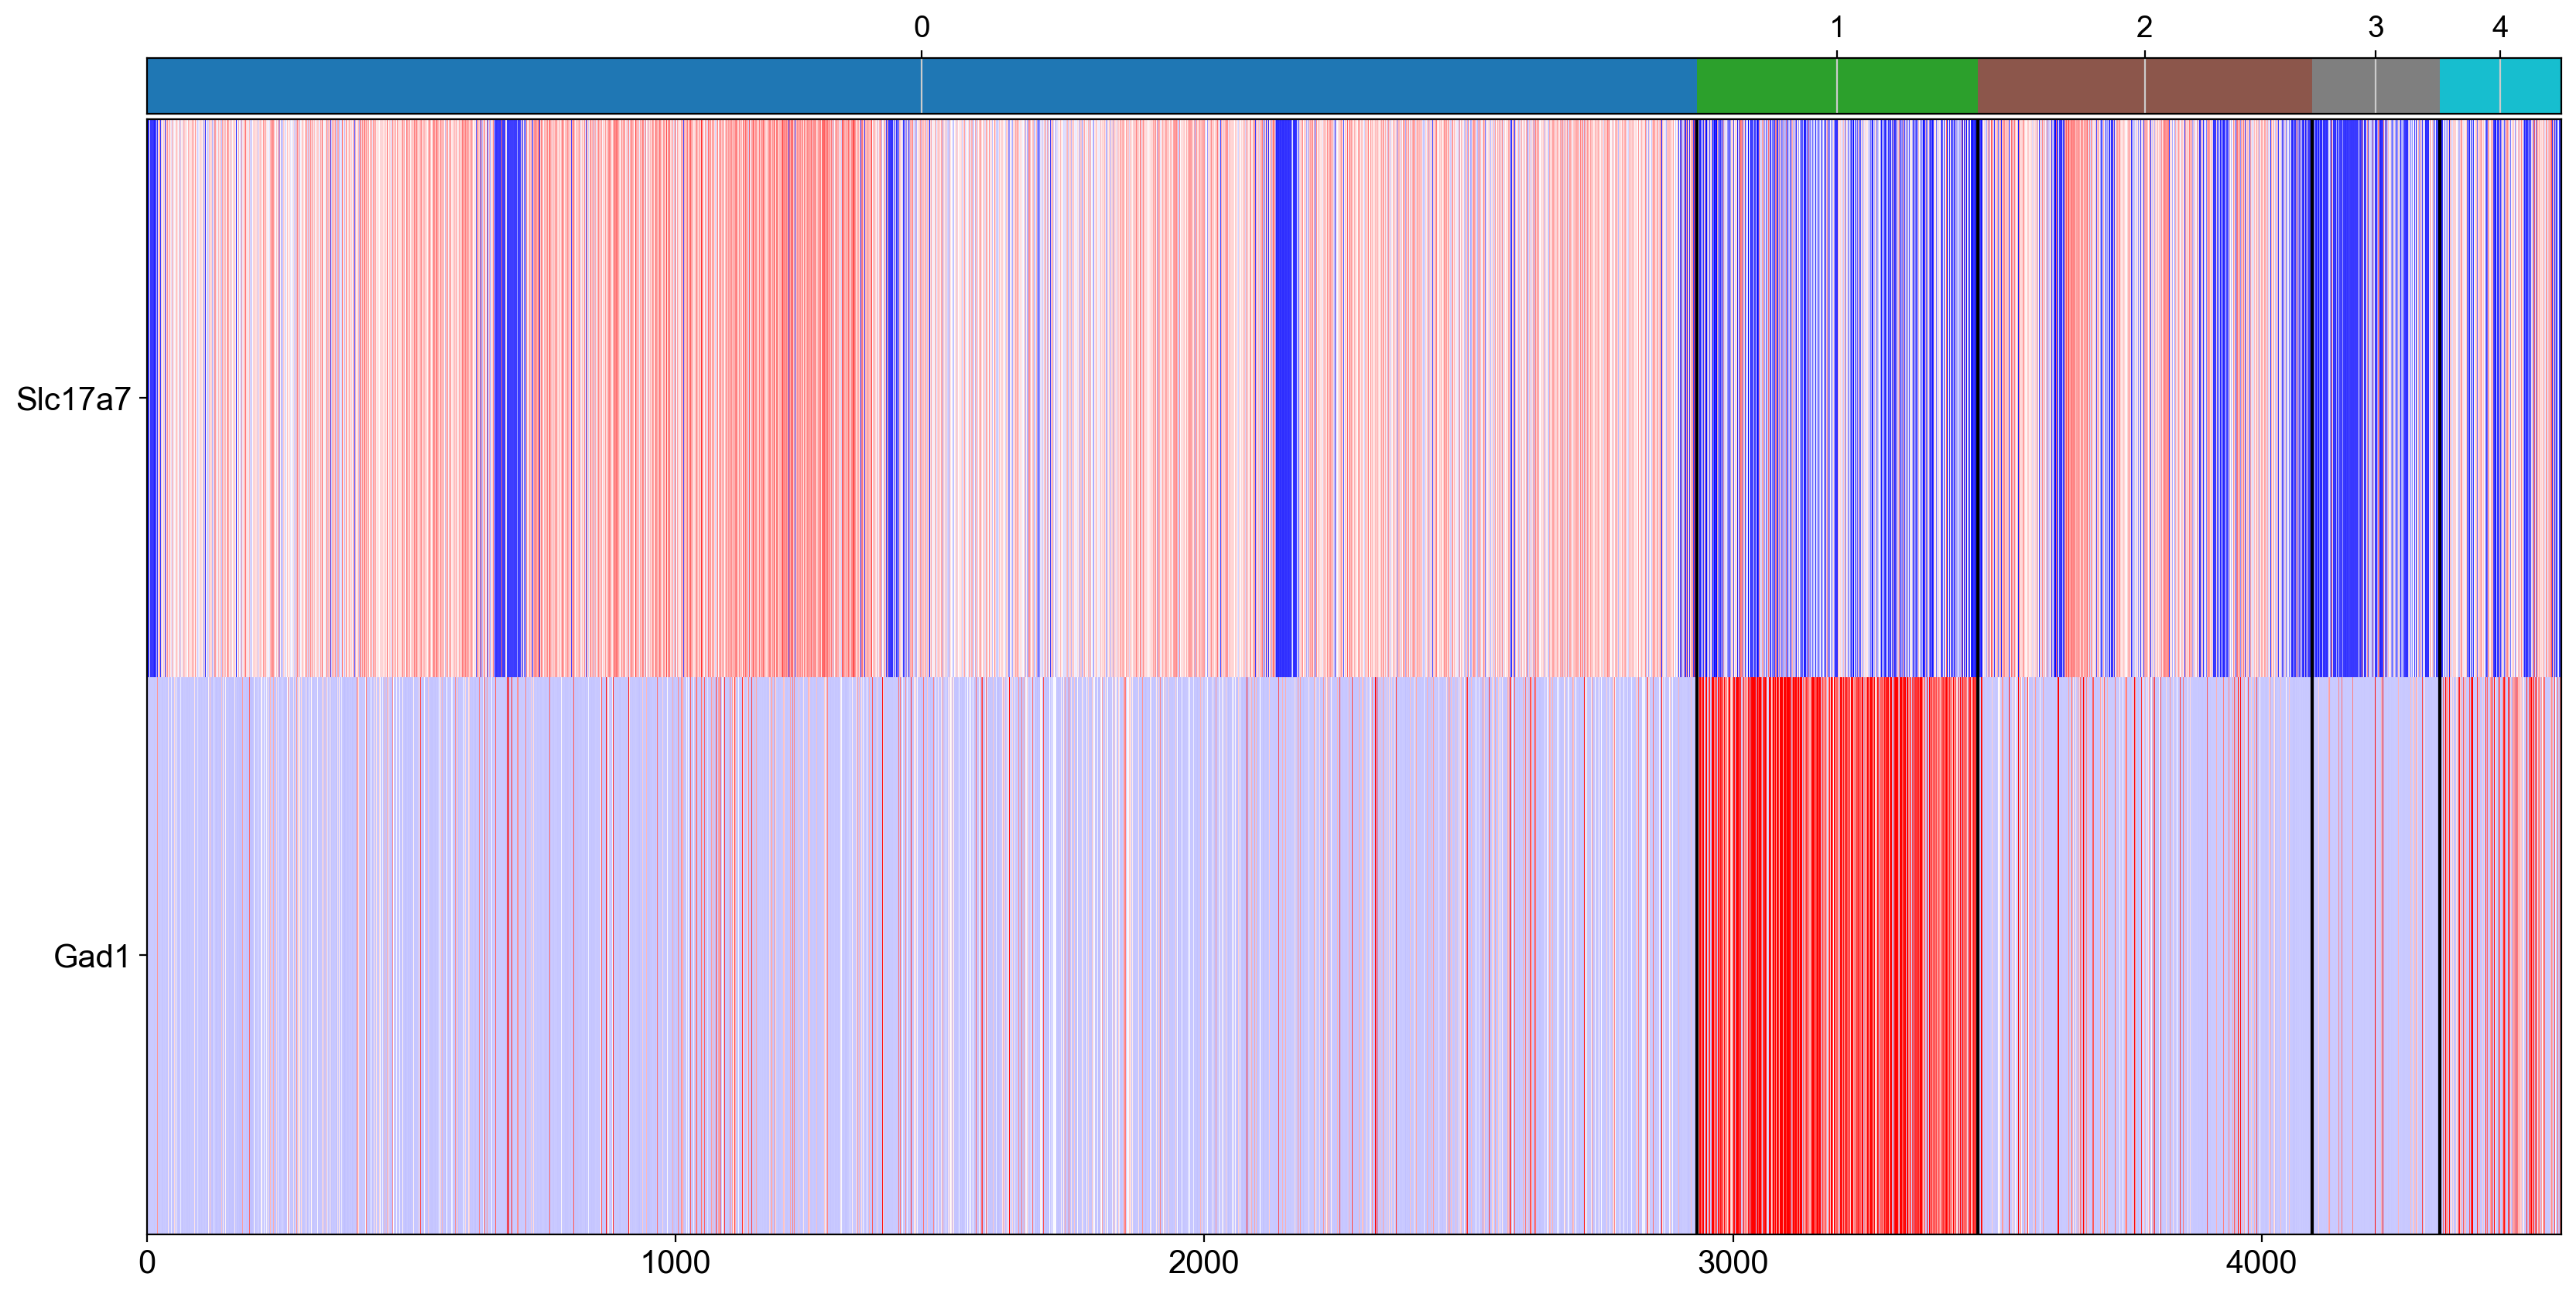

In [201]:
# Merge cluster

su.merge_multiple_clusters(adata, [0, 1, 2, 4])
su.merge_multiple_clusters(adata, [2, 3])

plt.figure(figsize=(20,10))
su.plot_heatmap_with_labels(adata, top_markers, 'louvain', show_axis=True, font_size=15)

In [208]:
sc.pl.heatmap(adata, top_markers, 'louvain')

KeyError: "Values ['Mobp'], from ['Slc17a7', 'Gad1', 'Mobp'], are not valid obs/ var names or indices."

In [ ]:
# Check expression profiles of selected gene markers
top_markers = ["Slc17a7", "Gad1"]

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, top_markers, show_axis=True, font_size=15)

In [ ]:
# Manually merge clusters (1)
merge_list = [0,1,2]

sdata.merge_multiple_clusters(merge_list)

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, top_markers, show_axis=True, font_size=15)

In [ ]:
# Manually merge clusters (2)
merge_list = [1,2,3]

sdata.merge_multiple_clusters(merge_list)

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, top_markers, show_axis=True, font_size=15)

In [ ]:
# Order the cluster if needed

sdata.order_clusters([0,2,1])

In [ ]:
# Set top-level colormap

top_color = ["#14a312", "#a8208d", "#616161"]
top_cmap = viz.get_colormap(top_color)

In [ ]:
# Find marker genes and plot the new heatmap

markers = anz.find_all_markers(sdata, test="bimod", only_pos=True, log_fc_thresh=0.1, min_pct=0.1, fdr_correct=True)

markers = list(anz.get_top_markers_of_cluster(markers, return_unique=True))

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, top_cmap, show_axis=True, font_size=10)

In [ ]:
# Plot new UMAP

viz.plot_dim(sdata, cmap=top_cmap)

In [ ]:
%%time

# Load position/morphology data

label_0 = np.load(os.path.join(os.path.join(base_path, data_folders[0]), "labels.npz"))["labels"]
label_1 = np.load(os.path.join(os.path.join(base_path, data_folders[1]), "labels.npz"))["labels"]

qhulls_0, coords_0, centroids_0 = viz.get_qhulls(label_0)
qhulls_1, coords_1, centroids_1 = viz.get_qhulls(label_1)

In [ ]:
# Plot cells cluster in BY3 (poly)
good_cells_0, colors_0 = sdata.get_cells_and_clusts_for_experiment(expt_id=0)
viz.plot_poly_cells_cluster(label_0, qhulls_0, colors_0, 
                            cmap=top_cmap, good_cells=good_cells_0, figscale=10)


In [ ]:
# Plot cells cluster in BY1 (poly)
good_cells_1, colors_1 = sdata.get_cells_and_clusts_for_experiment(expt_id=1)
viz.plot_poly_cells_cluster(label_1, qhulls_1, colors_1, 
                            cmap=top_cmap, good_cells=good_cells_1, figscale=10)


In [ ]:
# Add cluster label to the meta output
top_dict = {0:"Excitatory", 1:"Inhibitory", 2:"Non-neuronal"}
sdata.add_cluster_label(top_dict, 'top_label')

sdata._meta_out.head()

## 5. Excitatory neurons clustering

In [ ]:
# Get cell subset
ex_cells = sdata._meta['top_label'].to_numpy()
ex_cells = np.argwhere(ex_cells == 'Excitatory').flatten()
sdata._active_cells = ex_cells

In [ ]:
# PCA
anz.run_pca(sdata, n_components=50, use_genes=type_markers)
plt.figure(figsize=(12,10))

# Plot PCA explained variance
plt.subplot(2,2,1)
viz.plot_explained_variance(sdata)

# Plot PCA clusters
plt.subplot(2,2,2)
viz.plot_pca(sdata)

In [ ]:
# Clustering with SNN

max_pc = 4
n_neighbors = 60

anz.cluster_snn(sdata, max_pc=max_pc, k=n_neighbors)

# Compute UMAP 

anz.run_umap(sdata, max_pc=max_pc, n_neighbors=n_neighbors, min_dist=0.3)


# Plot tSNE/UMAP (with cluster labels)

viz.plot_dim(sdata)

In [ ]:
# Find marker genes and plot the heatmap

markers = anz.find_all_markers(sdata, test="bimod", only_pos=True, log_fc_thresh=0.1, min_pct=0.1, fdr_correct=True)

markers = list(anz.get_top_markers_of_cluster(markers, return_unique=True))

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, plt.cm.get_cmap('jet'), show_axis=True, font_size=10)

In [ ]:
# Set ex colormap

ex_color = ["#ff6600", "#e5ff00", "#000000", "#a89132", "#ff1100"]
ex_cmap = viz.get_colormap(ex_color)

In [ ]:
# Plot the new heatmap

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, ex_cmap, show_axis=True, font_size=10)

In [ ]:
# Plot new UMAP

viz.plot_dim(sdata, cmap=ex_cmap)

In [ ]:
# Plot cells cluster in BY3 (poly)

good_cells_0, colors_0 = sdata.get_cells_and_clusts_for_experiment(expt_id=0)
viz.plot_poly_cells_cluster(label_0, qhulls_0, colors_0, 
                            cmap=ex_cmap, good_cells=good_cells_0, figscale=10)

In [ ]:
# Plot cells cluster in BY1 (poly)

good_cells_1, colors_1 = sdata.get_cells_and_clusts_for_experiment(expt_id=1)
viz.plot_poly_cells_cluster(label_1, qhulls_1, colors_1, 
                            cmap=ex_cmap, good_cells=good_cells_1, figscale=10)

In [ ]:
# Add cluster label to the meta output

ex_dict = {0:"eL4", 1:"eL2/3", 2:"eL6", 3:"Other-Ex", 4:"eL5"}
sdata.add_cluster_label(ex_dict, 'sub_label')


sdata._meta_out.head()

## 6. Inhibitory neurons clustering

In [ ]:
# Get cell subset

inhi_cells = sdata._meta['top_label'].to_numpy()
inhi_cells = np.argwhere(inhi_cells == 'Inhibitory').flatten()
sdata._active_cells = inhi_cells

In [ ]:
# PCA
anz.run_pca(sdata, n_components=50, use_genes=type_markers)
plt.figure(figsize=(12,10))

# Plot PCA explained variance
plt.subplot(2,2,1)
viz.plot_explained_variance(sdata)

# Plot PCA clusters
plt.subplot(2,2,2)
viz.plot_pca(sdata)

In [ ]:
# Clustering with SNN

max_pc = 4
n_neighbors = 20

anz.cluster_snn(sdata, max_pc=max_pc, k=n_neighbors)

# Compute UMAP 

anz.run_umap(sdata, max_pc=max_pc, n_neighbors=n_neighbors, min_dist=0.3)


# Plot tSNE/UMAP (with cluster labels)

viz.plot_dim(sdata)

In [ ]:
# Find marker genes and plot the heatmap

markers = anz.find_all_markers(sdata, test="bimod", only_pos=True, log_fc_thresh=0.1, min_pct=0.1, fdr_correct=True)

markers = list(anz.get_top_markers_of_cluster(markers, return_unique=True))

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, plt.cm.get_cmap('jet'), show_axis=True, font_size=10)

In [ ]:
# Set ex colormap

inhi_color = ["#0223b8", "#09b500", "#00f0fc", "#a502b8"]
inhi_cmap = viz.get_colormap(inhi_color)

In [ ]:
# Plot the new heatmap

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, inhi_cmap, show_axis=True, font_size=10)

In [ ]:
# Plot new UMAP

viz.plot_dim(sdata, cmap=inhi_cmap)

In [ ]:
# Plot cells cluster in BY3 (poly)

good_cells_0, colors_0 = sdata.get_cells_and_clusts_for_experiment(expt_id=0)
viz.plot_poly_cells_cluster(label_0, qhulls_0, colors_0, 
                            cmap=inhi_cmap, good_cells=good_cells_0, figscale=10)

In [ ]:
# Plot cells cluster in BY1 (poly)

good_cells_1, colors_1 = sdata.get_cells_and_clusts_for_experiment(expt_id=1)
viz.plot_poly_cells_cluster(label_1, qhulls_1, colors_1, 
                            cmap=inhi_cmap, good_cells=good_cells_1, figscale=10)

In [ ]:
# Add cluster label to the meta output

inhi_dict = {0:"Pvalb", 1:"Sst", 2:"Vip", 3:"Other-Inhi"}
sdata.add_cluster_label(inhi_dict, 'sub_label')

## 7. Non-neuronal cells clustering

In [ ]:
# Get cell subset

non_cells = sdata._meta['top_label'].to_numpy()
non_cells = np.argwhere(non_cells == 'Non-neuronal').flatten()
sdata._active_cells = non_cells

In [ ]:
# PCA
anz.run_pca(sdata, n_components=50, use_genes=type_markers)
plt.figure(figsize=(12,10))

# Plot PCA explained variance
plt.subplot(2,2,1)
viz.plot_explained_variance(sdata)

# Plot PCA clusters
plt.subplot(2,2,2)
viz.plot_pca(sdata)

In [ ]:
# Clustering with SNN

max_pc = 3
n_neighbors = 50

anz.cluster_snn(sdata, max_pc=max_pc, k=n_neighbors)

# Compute UMAP 

anz.run_umap(sdata, max_pc=max_pc, n_neighbors=n_neighbors, min_dist=0.3)


# Plot tSNE/UMAP (with cluster labels)

viz.plot_dim(sdata)

In [ ]:
# Find marker genes and plot the heatmap

markers = anz.find_all_markers(sdata, test="bimod", only_pos=True, log_fc_thresh=0.1, min_pct=0.1, fdr_correct=True)

markers = list(anz.get_top_markers_of_cluster(markers, return_unique=True))

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, plt.cm.get_cmap('jet'), show_axis=True, font_size=10)

In [ ]:
# Set ex colormap

non_color = ["#ad005a", "#bababa", "#3f98b0", "#e491ed"]
non_cmap = viz.get_colormap(non_color)

In [ ]:
# Plot the new heatmap

plt.figure(figsize=(20,10))
viz.plot_heatmap_with_labels(sdata, markers, non_cmap, show_axis=True, font_size=10)

In [ ]:
# Plot new UMAP

viz.plot_dim(sdata, cmap=non_cmap)

In [ ]:
# Plot cells cluster in BY3 (poly)

good_cells_0, colors_0 = sdata.get_cells_and_clusts_for_experiment(expt_id=0)
viz.plot_poly_cells_cluster(label_0, qhulls_0, colors_0, 
                            cmap=non_cmap, good_cells=good_cells_0, figscale=10)

In [ ]:
# Plot cells cluster in BY1 (poly)

good_cells_1, colors_1 = sdata.get_cells_and_clusts_for_experiment(expt_id=1)
viz.plot_poly_cells_cluster(label_1, qhulls_1, colors_1, 
                            cmap=non_cmap, good_cells=good_cells_1, figscale=10)

In [ ]:
# Add cluster label to the meta output

non_dict = {0:"SMC", 1:"Oligo", 2:"Astro", 3:"Endo"}
sdata.add_cluster_label(non_dict, 'sub_label')

## 8. Overall results

In [ ]:
# Get cell subset
sdata._active_cells = None

In [ ]:
# PCA
anz.run_pca(sdata, n_components=50, use_genes=type_markers)
plt.figure(figsize=(12,10))

# Plot PCA explained variance
plt.subplot(2,2,1)
viz.plot_explained_variance(sdata)

# Plot PCA clusters
plt.subplot(2,2,2)
viz.plot_pca(sdata)

In [ ]:
# Change meta

new_order = list(ex_dict.values()) + list(inhi_dict.values()) + list(non_dict.values())
sdata._meta['sub_label'] = sdata._meta['sub_label'].astype('category')
sdata._meta['sub_label'].cat.reorder_categories(new_order, inplace=True)

# Change clust info for ploting

sdata._clusts = sdata._meta['sub_label'].cat.codes.to_numpy()

# Get color map for all 

total_cmap = viz.get_colormap(ex_color + inhi_color + non_color)

In [ ]:
# Clustering with SNN

max_pc = 7
n_neighbors = 40

# Compute UMAP 

anz.run_umap(sdata, max_pc=max_pc, n_neighbors=n_neighbors, min_dist=0.3)


# Plot tSNE/UMAP (with cluster labels)

viz.plot_dim(sdata, colorby='sub_label', cmap=total_cmap)

In [ ]:
# Find marker genes and plot the heatmap

markers_df = anz.find_all_markers(sdata, test="bimod", only_pos=True, log_fc_thresh=0.25, min_pct=0.1, fdr_correct=True)

markers = list(anz.get_top_markers_of_cluster(markers_df, return_unique=True))

plt.figure(figsize=(20,15))
viz.plot_heatmap_with_labels(sdata, markers, total_cmap, show_axis=True, font_size=10)

In [ ]:
# Plot cells cluster in BY3 (poly)

good_cells_0, colors_0 = sdata.get_cells_and_clusts_for_experiment(expt_id=0, colorby='sub_label')
viz.plot_poly_cells_cluster(label_0, qhulls_0, colors_0, 
                            cmap=total_cmap, good_cells=good_cells_0, figscale=10)

In [ ]:
# Plot cells cluster in BY1 (poly)

good_cells_1, colors_1 = sdata.get_cells_and_clusts_for_experiment(expt_id=1, colorby='sub_label')
viz.plot_poly_cells_cluster(label_1, qhulls_1, colors_1, 
                            cmap=total_cmap, good_cells=good_cells_1, figscale=10)

In [ ]:
# Add locations

total_centroids = np.array(centroids_0 + centroids_1, dtype='int16')
sdata.add_location(total_centroids)

sdata._meta_out.head()

In [ ]:
# Save the meta data

for i, folder in enumerate(data_folders):
    out_path = os.path.join(base_path, folder, 'output')

    # get meta for current sample 
    curr_meta = sdata.get_metaout_by_experiment(i)
    
    # output
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    curr_meta.to_csv(os.path.join(out_path, 'meta_output.csv'))
    print(f"Saving meta: {folder}")